<a href="https://colab.research.google.com/github/arahogc/Whats_In_A_Bottle/blob/Jess/description_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Winemag-data_first150K Data Preprocessing

### **Overview**

**Purpose:** To preprocess the winemag data so that it can be run through a machine learning model to predict price and/or rating (points). 

**Cleaning To-Do list:**
1. Check the null values in each column
2. Drop columns with large number of null values (>50% null)
3. For columns with null values that we want to keep for model training, fill the na values with something
4. Remove rows with null values that we're okay with excluding
5. Bin data in columns with more than X unique values -> Need to think about this more because there are a few columns that have a significant number of unique values with a count of 1
6. Tokenize the description column
7. Remove Stop words from the tokenized description
8. Count the number of tokens and add a new column to the df
9. Encode the filtered description tokens
10. Encode the remaining columns after cleaned and binned
11. Export the dataframe as a csv file and store in database


### **Import Dependencies and Initialize the Spark Session**

In [1]:
# Initialize Spark
import os

# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
#spark_version = 'spark-2.4.5'
spark_version = 'spark-3.0.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad

In [2]:
# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.4.5

! pip install pyspark

# Install nltk
! pip install nltk

  Using cached https://files.pythonhosted.org/packages/31/46/5c5a2bda407f693126386da5378f132e5e163fa6dfa46109548270348786/spark_nlp-2.4.5-py2.py3-none-any.whl


In [3]:
# Import spark nlp
import sparknlp
spark = sparknlp.start()

In [4]:
# Import dependencies
import pandas as pd 

from pyspark import SparkFiles
from pyspark.sql import SparkSession

from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Import the stop words library
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, Normalizer, StringIndexer

In [5]:
# Start Spark session
spark = SparkSession.builder.appName("Whats_In_A_Bottle").getOrCreate()

## Data Cleaning:

### **Check the null values in each column and drop columns with large number of null values (>50% null)**

In [6]:
# Read in data from S3 Buckets
url ="https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_first150k.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("winemag-data_first150k.csv"), sep=",", header=True)
df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|         region_2|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|             Napa|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|             null|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley

In [7]:
# Get count of both null and missing values in pyspark
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|region_2|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+
|  0|      5|          1|      45733|     6|13697|      11|   25059|   89963|      6|    17|
+---+-------+-----------+-----------+------+-----+--------+--------+--------+-------+------+



In [8]:
# Drop the region_2 column
df = df.drop("region_2")
df.show()

+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|_c0|country|         description|         designation|points|price|          province|            region_1|           variety|              winery|
+---+-------+--------------------+--------------------+------+-----+------------------+--------------------+------------------+--------------------+
|  0|     US|This tremendous 1...|   Martha's Vineyard|    96|235.0|        California|         Napa Valley|Cabernet Sauvignon|               Heitz|
|  1|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|110.0|    Northern Spain|                Toro|     Tinta de Toro|Bodega Carmen Rod...|
|  2|     US|Mac Watson honors...|Special Selected ...|    96| 90.0|        California|      Knights Valley|   Sauvignon Blanc|            Macauley|
|  3|     US|This spent 20 mon...|             Reserve|    96| 65.0|            Oregon|   Willamette Valle

In [9]:
#Count the region unique values
region_replaced = df.groupby(df.region_1).count().distinct()
region_replaced.orderBy(col('count').desc()).show()

+--------------------+-----+
|            region_1|count|
+--------------------+-----+
|                null|25059|
|         Napa Valley| 6205|
|Columbia Valley (WA)| 4975|
|             Mendoza| 3586|
|Russian River Valley| 3571|
|          California| 3460|
|         Paso Robles| 3053|
|   Willamette Valley| 2096|
|               Rioja| 1893|
|             Toscana| 1885|
|       Sonoma County| 1852|
|Brunello di Monta...| 1746|
|             Sicilia| 1701|
|              Alsace| 1574|
|        Sonoma Coast| 1473|
|            Carneros| 1458|
|    Dry Creek Valley| 1398|
|              Barolo| 1397|
|        Finger Lakes| 1372|
|           Champagne| 1369|
+--------------------+-----+
only showing top 20 rows



In [10]:
# Replace null values in the region_1 and designation columns with "other" since we'll keep these columns
# consider dropping designation column if it becomes an issue later
replaced_df = df.na.fill({"region_1": "N/A", "designation":"N/A"})

In [11]:
# Check to see if the region null values have been replaced with "N/A"
replaced_region_counts = replaced_df.groupby(replaced_df.region_1).count().distinct().orderBy(col('count').desc())
replaced_region_counts.show()

+--------------------+-----+
|            region_1|count|
+--------------------+-----+
|                 N/A|25059|
|         Napa Valley| 6205|
|Columbia Valley (WA)| 4975|
|             Mendoza| 3586|
|Russian River Valley| 3571|
|          California| 3460|
|         Paso Robles| 3053|
|   Willamette Valley| 2096|
|               Rioja| 1893|
|             Toscana| 1885|
|       Sonoma County| 1852|
|Brunello di Monta...| 1746|
|             Sicilia| 1701|
|              Alsace| 1574|
|        Sonoma Coast| 1473|
|            Carneros| 1458|
|    Dry Creek Valley| 1398|
|              Barolo| 1397|
|        Finger Lakes| 1372|
|           Champagne| 1369|
+--------------------+-----+
only showing top 20 rows



In [12]:
# Check to see if the designation null values have been replaced with "N/A"
replaced_designation_counts = replaced_df.groupby(replaced_df.designation).count().distinct().orderBy(col('count').desc())
replaced_designation_counts.show()

+--------------------+-----+
|         designation|count|
+--------------------+-----+
|                 N/A|45733|
|             Reserve| 2752|
|             Reserva| 1810|
|              Estate| 1571|
|       Barrel sample| 1326|
|             Riserva|  754|
|       Barrel Sample|  639|
|                Brut|  624|
|             Crianza|  503|
|        Estate Grown|  449|
|      Estate Bottled|  396|
|                 Dry|  374|
|        Gran Reserva|  330|
|            Old Vine|  330|
|           Brut Rosé|  248|
|           Extra Dry|  244|
|     Vieilles Vignes|  225|
|Bien Nacido Vineyard|  195|
|                Rosé|  180|
|Late Bottled Vintage|  171|
+--------------------+-----+
only showing top 20 rows



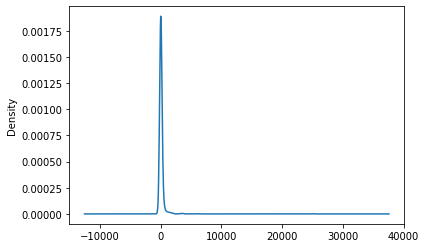

In [13]:
# Visualize the unique value counts with a histogram
import matplotlib.pyplot as plt

# Convert to pandas df
replaced_df_pd = replaced_df.toPandas()

# visualize the value counts of region_1
region_counts = replaced_df_pd['region_1'].value_counts()
region_counts.plot.density()

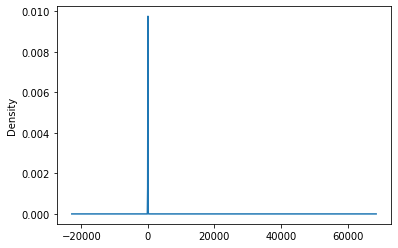

In [14]:
# visualize the value counts of designation
designation_counts = replaced_df_pd['designation'].value_counts()
designation_counts.plot.density()

In [15]:
# Drop rows with null values
dropna_df = replaced_df.na.drop()

# Check that the null values have been removed
dropna_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dropna_df.columns]).show()

+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|_c0|country|description|designation|points|price|province|region_1|variety|winery|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+
|  0|      0|          0|          0|     0|    0|       0|       0|      0|     0|
+---+-------+-----------+-----------+------+-----+--------+--------+-------+------+



In [16]:
# Create a function to return the length of a list
def word_list_length(word_list):
  return len(word_list)

In [17]:
# Create a user defined function
count_tokens = udf(word_list_length, IntegerType())

In [18]:
# Tokenize sentences
tokenizer = Tokenizer(inputCol="description", outputCol="words")
tokenizer

Tokenizer_3d43c22538a8

In [26]:
# Create our Tokenizer
tokenizer = Tokenizer(inputCol="description", outputCol="words")

# Transform DataFrame
tokenized_df = tokenizer.transform(dropna_df)

# Select the needed column and don't truncate results
tokenized_df = tokenized_df.withColumn("tokens", count_tokens(col("words")))
tokenized_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Use the word remover
# Run the remover
remover = StopWordsRemover(inputCol="words",outputCol="filtered")
# Tranform and show data
removed_df = remover.transform(tokenized_df)
removed_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Select the needed column and don't truncate results
filtered_tokens_df = removed_df.withColumn("filtered_tokens", count_tokens(col("filtered")))
filtered_tokens_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
! pip install nltk

In [30]:
# Run the hashing term frequency
hashing = HashingTF(inputCol="filtered", outputCol="hashedValues", numFeatures=pow(2,18))

# Transform into a DF
hashed_df = hashing.transform(filtered_tokens_df)
hashed_df.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Fit the IDF on the data set
idf = IDF(inputCol="hashedValues", outputCol="features")
idfModel = idf.fit(hashed_df)
rescaledData = idfModel.transform(hashed_df)

# Display the DataFrame
rescaledData.show(truncate=False)

+---+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+------+-----+------------------+-------------------------+------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
# Connect to GDrive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [34]:
# Convert Spark df to Pandas df 
cleaned_df = rescaledData.toPandas()

In [35]:
# Export dataframe to csv
cleaned_df.to_csv('winemag-data_cleaning_inprogress.csv')
!cp winemag-data_cleaning_inprogress.csv "drive/My Drive/UCB Data Bootcamp/Whats_In_A_Bottle"

In [36]:
# Connect to Database
    # RDS Endpoint Link: whats-in-a-bottle.cuvwsdzowgas.us-west-1.rds.amazonaws.com
    # username: postgres
    # password: bootcamp-whats-in-a-bottle



In [42]:
# Save dataframe directly to s3?
cleaned_df.to_csv('https://whats-in-a-bottle.s3-us-west-1.amazonaws.com/winemag-data_cleaning_inprogress.csv', index=False)

HTTPError: ignored